# Prise en main de python

Dans ce dernier TP, nous allons mettre en application les notions vues précédemment pour répondre à une question spécifique. L'objectif et d'avoir une **estimation de la surface brulée** suite aux **incendies qui ont touché la Gironde en juillet 2022**.


In [1]:
# Importer toutes les librairies nécessaires avec des acronymes
import numpy as np  # permet de gérer des tableaux multidimensionnels
import xarray as xr  # permet de lire des fichiers de données geo-référencés
import datetime  # permet de manipuler des dates
import dask  # permet de faire du calcul parallélisé efficace
import re  # permet de trouver des caractères particuliers dans des chaines de caractères
import matplotlib.pyplot as plt  # permet d'afficher des graphiques et des images
from matplotlib import rcParams  # matplotlib parameters

# Configuration de dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

# Parameters for matplotlib
plt.style.use('default')
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams.update({'font.size': 15})

# Fonction pour faciliter le TP
def product_str_to_datetime(product_name: str) -> datetime.date:
    """
    product_str_to_datetime returns a ``datetime.date`` object for the date of the given product.
    Works for both copernicus and theia providers.

    Arguments
    =========

    1. product_name: ``str``
        name or path of the product

    Returns
    =======

    1. product_date: ``datetime.date``
        datetime.date object, date of the product
    """

    # Search for a date pattern (yyyymmdd) in the product name or path
    try:
        match = re.search('\d{4}\d{2}\d{2}', product_name)
        format = '%Y%m%d'
        datetime_object = datetime.datetime.strptime(match[0], format)
        return datetime_object.date()
    except TypeError:
        pass

# Définir les chemins vers les différentes images
data_path = '../TP1/DATA/'
nir_path_before = data_path + 'SENTINEL2A_20220712-110900-471_L2A_T30TXQ_C_V3-0/SENTINEL2A_20220712-110900-471_L2A_T30TXQ_C_V3-0_FRE_B8.tif'
swir_path_before = data_path + 'SENTINEL2A_20220712-110900-471_L2A_T30TXQ_C_V3-0/SENTINEL2A_20220712-110900-471_L2A_T30TXQ_C_V3-0_FRE_B12.tif'
nir_path_after = data_path + 'SENTINEL2A_20220801-110857-935_L2A_T30TXQ_C_V3-0/SENTINEL2A_20220801-110857-935_L2A_T30TXQ_C_V3-0_FRE_B8.tif'
swir_path_after = data_path + 'SENTINEL2A_20220801-110857-935_L2A_T30TXQ_C_V3-0/SENTINEL2A_20220801-110857-935_L2A_T30TXQ_C_V3-0_FRE_B12.tif'
OSO_classif_path = data_path + 'T30TXQ_OSO_2022.tif'

## Normalized Burn Ratio (**NBR**)

Le [Normalized Burn Ratio](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio) est un indice similaire au NDMI (*moisture index*), mais il n'utilise pas exactement la même bande spectrale **SWIR** (la bande B12 plutôt que la B11). Il permet de **mettre en évidence les zones brûlées** en calculant la **différence entre l'indice pré-feu et post-feu**. L'ampleur de la différence permet de déterminer la **sévérité** du feu qui a touché chaque pixel ("l'ampleur" est sujette à interprétation). C'est un indice qui est le plus efficace s'il est calculé à partir d'images **prises juste avant** et **juste après** le feu.

$$ NBR = \frac{NIR - SWIR}{NIR + SWIR} $$

Nous allons commencer par ouvrir les bandes B8 et B12 d'une manière nouvelle. Le but est de gérer plus facilement l'aspect **multi-temporel**. La bande B12 n'a pas la même résolution que la bande B8. Commencons par mettre nos deux `Datasets` à la même **résolution**. Nous allons **augmenter la dimension de la bande B12**.

> - ***Ouvrir** les **4 images** dans **deux `Datasets`** avec la méthode `.open_mfdataset()` de `xarray` : un pour les **bandes B8** et un pour les **bandes B12**. On pourra appliquer les méthodes `.squeeze()` et `.rename()`.*
> - ***Afficher** les `Datasets` obtenus (avec la fonction `display()`), que peut-on **améliorer** ? Les Datasets ont-il la **même structure** ? Quelles **informations manque-t-il** ?*
> - ***Changer la résolution** de la bande B12 (swir) avec la méthode `.interp(x = coords, y = coords, method = 'linear')`.*

In [2]:
# Ouvrir les bandes avec xarray
nir = xr.open_mfdataset([nir_path_before, nir_path_after], combine='nested', concat_dim='time', chunks='auto').squeeze(dim='band', drop=True).rename({'band_data': 'nir'})
swir = xr.open_mfdataset([swir_path_before, swir_path_after], combine='nested', concat_dim='time', chunks='auto').squeeze(dim='band', drop=True).rename({'band_data': 'swir'})

# Augmenter la résolution du dataset swir
swir = swir.interp(x=nir.x.values, y=nir.y.values, method='linear')

# Afficher les datasets
display(nir)
display(swir)

<xarray.Dataset>
Dimensions:      (x: 10980, y: 10980, time: 2)
Coordinates:
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5e+06 5e+06 5e+06 ... 4.89e+06 4.89e+06 4.89e+06
    spatial_ref  int64 0
Dimensions without coordinates: time
Data variables:
    nir          (time, y, x) float32 dask.array<chunksize=(1, 3055, 10980), meta=np.ndarray>

<xarray.Dataset>
Dimensions:      (time: 2, y: 10980, x: 10980)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5e+06 5e+06 5e+06 ... 4.89e+06 4.89e+06 4.89e+06
Dimensions without coordinates: time
Data variables:
    swir         (time, y, x) float32 dask.array<chunksize=(1, 10980, 10980), meta=np.ndarray>

<b><u style="color: red;">COMMENTAIRE</u></b>

Nous pouvons voir que suite à l'importation et au redimensionnement de la bande 12, nous avons deux `Datasets` de même taille. Cependant, comme nous étudions le cas d'évolution de surface brulée, il nous manque une donnée importante: la variable de temps.

### Manipuler les Datasets

Avant de commencer la partie clé du TP, nous allons travailler sur les `Datasets` pour les rendres **plus lisibles** et plus f**aciles à manipuler**.

Nous allons **créer** la `coordonnée` **'time'** et lui **attribuer des valeurs**.

Nous allons ensuite **combiner** ces deux `Datasets` en un seul, nous travaillerons par la suite qu'avec ce `Dataset`.

Pour finir, nous allons **sélectionner** seulement une fenêtre spatiale du `Dataset` total.

> - ***Créer une liste de 2 dates** avec la fonction `product_str_to_datetime()` et les noms de fichiers.*
> - ***Créer une coordonnée `'time'`** et lui **attribuer** comme valeur les deux dates extraites.*
> - ***Combiner** ces deux `Datasets` avec la méthode `.merge()` de `xarray`.*
> - ***Sélectionner** une fenêtre spatiale du Dataset avec la méthode `.sel()`.*
> - ***Afficher** le `Dataset` obtenu. Que peut-on en dire ?*

> Coordonnées pour sélectionner une partie du `Dataset` :

```py
xmin = 635000
xmax = 704500
ymin = 4915300
ymax = 4949400
```

> N'hésitez pas à afficher les `Datasets` obtenus après chaque étape pour s'assurer des bons résultats intermédiaires.

In [3]:
# Créer une liste de dates
dates = [product_str_to_datetime(nir_path_before), product_str_to_datetime(nir_path_after)]

# Créer la coordonnée 'time' dans chaque dataset
nir['time'] = dates
swir['time'] = dates

# Combiner les deux datasets
dataset = xr.merge([nir, swir])

# Sélectionner une fenêtre spatiale
xmin = 635000
xmax = 704500
ymin = 4915300
ymax = 4949400
dataset = dataset.sel(y=slice(ymax, ymin, 1), x=slice(xmin, xmax, 1))

# Afficher le dataset résultant
display(dataset)

<xarray.Dataset>
Dimensions:      (x: 6950, y: 3410, time: 2)
Coordinates:
  * x            (x) float64 6.35e+05 6.35e+05 6.35e+05 ... 7.045e+05 7.045e+05
  * y            (y) float64 4.949e+06 4.949e+06 ... 4.915e+06 4.915e+06
    spatial_ref  int64 0
  * time         (time) object 2022-07-12 2022-08-01
Data variables:
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1046, 6950), meta=np.ndarray>
    swir         (time, y, x) float32 dask.array<chunksize=(1, 3410, 6950), meta=np.ndarray>

<b><u style="color: red;">COMMENTAIRE</u></b>

Après avoir combiner les données nous avons un `Dataset` contenant les variables de dimension et de temps, ainsi que les matrices de données de NIR (proche infra-rouge) et SWIR (infra-rouge à ondes courtes).

In [4]:
# Libérer la mémoire de la partie précédente
del nir, swir

## Calculer le NBR

Nous allons maintenant calculer le **NBR** pour chaque date dans une nouvelle **data variable** de notre `Dataset` puis l'afficher.

> - ***Créer** une nouvelle **`data variable`** `nbr` qui contiendra le **NBR** pour chaque date.*
> - *Afficher le **NBR** pour chaque date avec la méthode `.plot.imshow()` et en utilisant l'argument `col = 'time'` pour afficher les **deux dates sur le même graphique**. On utilisera la `colormap` `'RdYlGn'`.*

/home/mlk3703a/.conda/envs/cours/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.05, 'Normalized Burn Ratio')

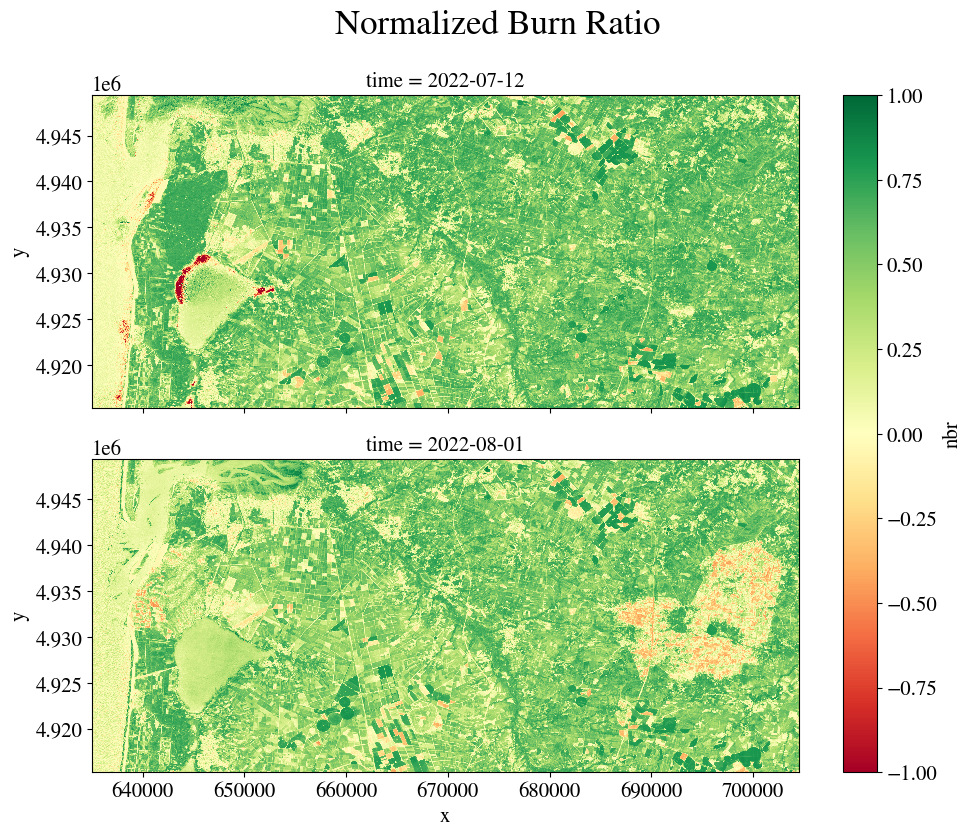

In [5]:
# Calculer le NBR dans une nouvelle data variable
dataset['nbr'] = (dataset.nir - dataset.swir) / (dataset.nir + dataset.swir)

# Afficher les deux images NBR
dataset.nbr.plot.imshow(figsize=(10, 8), cmap='RdYlGn', col='time', col_wrap=1)
plt.suptitle('Normalized Burn Ratio', y=1.05, fontsize=25)

<b><u style="color: red;">COMMENTAIRE</u></b>

Grâce à ces représentations nous pouvons voir une zone à l'est de l'image avec un indice plus faible que les alentours. Il s'agit d'une zone brulée.

## Masquer la donnée

Le NBR est adapté pour les surfaces continentales, il ne se comporte cependant pas bien sur les surfaces en eau (il peut y avoir de faux positifs sur les surfaces en eau par exemple). Il va donc falloir masquer les surfaces en eau.

> - ***Au choix**, construire un **masque d'eau** ou utiliser la **classification OSO** pour **masquer les pixels non valides**.*
> - ***Afficher** le **NBR** masqué.* 

> ***Attention :*** il ne faut pas oublier de **sélectionner la même fenêtre spatiale** pour la classification, sinon les ensembles de données n'auront pas la même taille.

/home/mlk3703a/.conda/envs/cours/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.05, 'Normalized Burn Ratio masked')

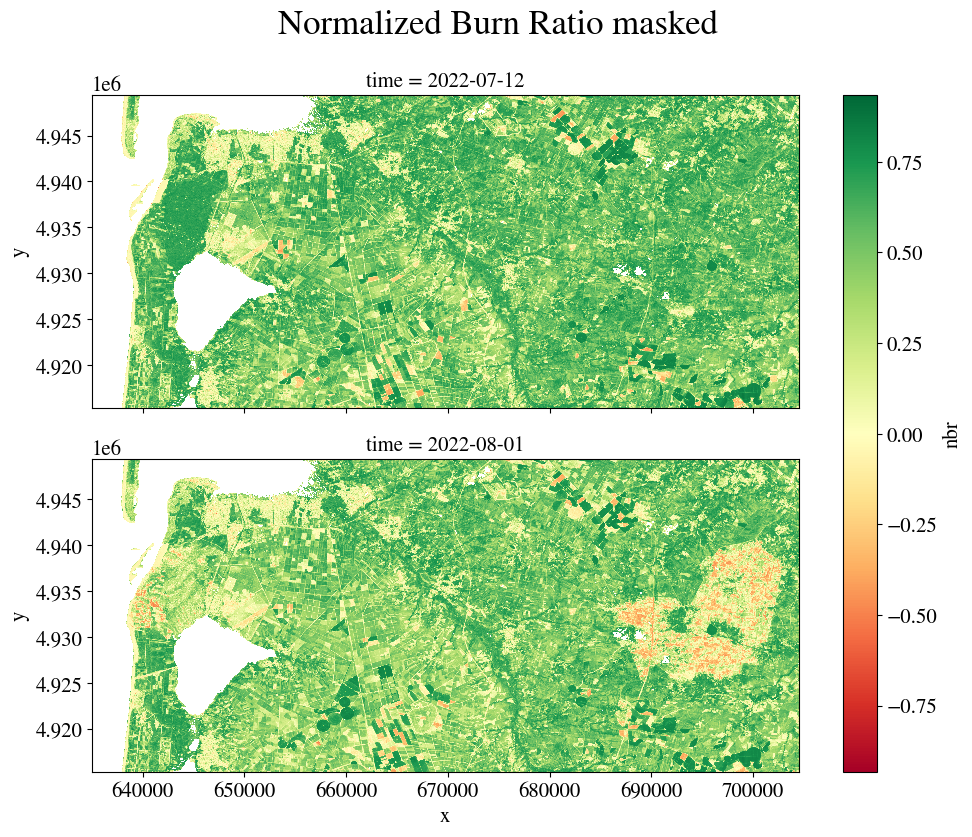

In [6]:
# Ouvrir la classification OSO ou calculer l'indice d'eau pour masquer le NBR
OSO_classif = xr.open_dataarray(OSO_classif_path).squeeze(dim='band', drop=True).astype(np.uint8)

# Masquer la donnée
dataset['nbr'] = dataset.nbr * xr.where(OSO_classif == 23, np.NaN, 1)

# Afficher les deux images NBR masquées
dataset.nbr.plot.imshow(figsize=(10, 8), cmap='RdYlGn', col='time', col_wrap=1)
plt.suptitle('Normalized Burn Ratio masked', y=1.05, fontsize=25)

<b><u style="color: red;">COMMENTAIRE</u></b>

Ici nous appliquons le masque d'eau par classification en utilisant la donnée OSO.

In [7]:
# Libérer la mémoire de la partie précédente
del dataset['nir'], dataset['swir']

On peut voir des différences, mais il est difficile de quantifier **l'ampleur du changement** avec deux images comme ça. Il faut calculer la **différence entre ces deux dates** (pre-feu $-$ post-feu) pour voir quelque chose apparaître.

$$\Delta NBR = NBR_{pre} - NBR_{post}$$

> - ***Calculer** la **différence entre les deux** dates dans une nouvelle `data variable` `delta_nbr`. On pourra utiliser la méthode `.isel()` pour **sélectionner une date par son indice**.*
> - ***Afficher** l'image obtenue avec la `colormap` `'RdYlGn_r'`.*

Que voit-on alors ?

/home/mlk3703a/.conda/envs/cours/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'Normalized Burn Ratio difference')

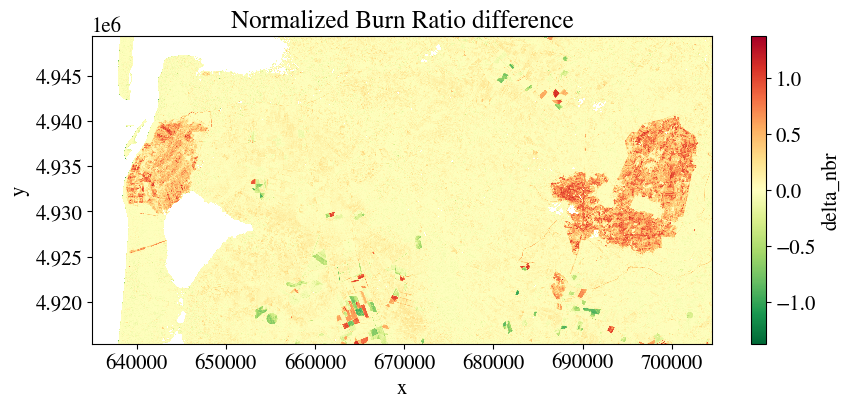

In [8]:
# Calculer la différence entre les deux dates
dataset['delta_nbr'] = dataset.nbr[0] - dataset.nbr[1]

# Afficher la différence
dataset.delta_nbr.plot.imshow(cmap='RdYlGn_r', figsize=(10, 4))
plt.title('Normalized Burn Ratio difference')

On peut voir des zones apparaître. Les **fortes valeurs** correspondent à des **zones brûlées** et les **faibles valeurs** à des **zones qui ont reverdi**. Pour aller plus loin dans l'analyse, il va falloir **déterminer des seuils** et **classer** les pixels dans des catégories correspondantes.

## Sévérité du feu

En se basant sur la littérature, on peut définir **5 catégories** pour évaluer la sévérité d'un feu :

| Catégorie     | Intervalles         |
|---------------|---------------------|
| Repousse      | $< -0.1$            |
| Pas de feu    | $- 0.1 \; à \; 0.15$|
| Feu faible    | $0.15 \; à \; 0.27$ |
| Feu moyen     | $0.27 \; à \; 0.66$ |
| Feu important | $> 0.66$            |

À partir de ces catégories, nous allons créer **une classification**. Elle comportera donc **5 valeurs** comme suit :

| Catégorie     | Valeurs  |
|---------------|----------|
| Repousse      | 1        |
| Pas de feu    | 2        |
| Feu faible    | 3        |
| Feu moyen     | 4        |
| Feu important | 5        |

On laissera les données masquées telles quel.

> - ***Créer** une nouvelle `data variable` `burn_severity` qui contiendra la **classification** créée à partir du `delta_nbr`. On peut réaliser la construction de la classification en **une** ou **plusieurs étapes**.*
> - ***Créer** une `colormap` avec **5 couleurs** à partir de la `colormap` `'RdYlGn_r'` et une légende. **Afficher** ensuite la classification.*

Text(0.5, 1.0, 'Burn Severity')

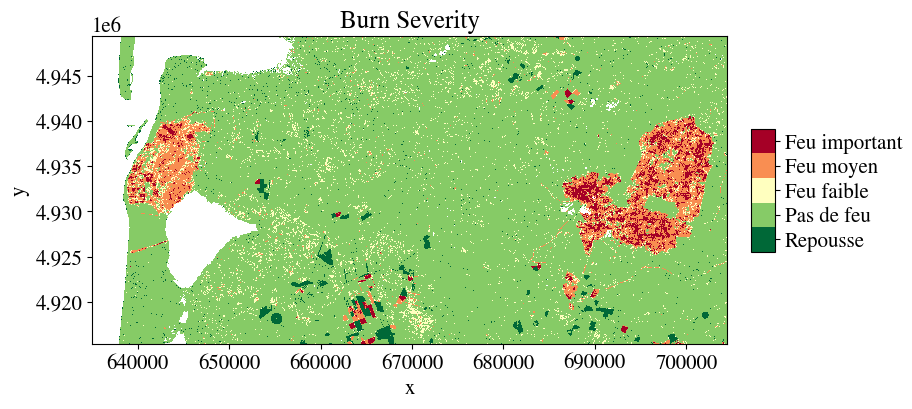

In [9]:
# [AVANCÉ] Créer une fonction vectorisée pour créer la classification
from numba import njit, prange  # permet de vectoriser des fonctions

@njit(nogil = True, parallel = True)
def convert_nbr_index(array: np.ndarray, thresholds: np.ndarray) -> np.ndarray:
    """
    Takes in a numpy array with normalized burn ratio values
    and outputs a classification array with integer values
    corresponding to the burn severity.

    Arguments
    =========

    1. array: ``np.ndarray``
        Delta NBR numpy array
    2. thresholds: ``np.ndarray``
        list of threshold values (floats)

    Returns
    =======

    array: ``np.ndarray``
        output classification array
    """
    
    for i in prange(len(array)):
        for j in prange(len(array[0])):
            if array[i, j] < thresholds[0]:
                array[i, j] = 1
            elif (array[i, j] >= thresholds[0]) & (array[i, j] < thresholds[1]):
                array[i, j] = 2
            elif (array[i, j] >= thresholds[1]) & (array[i, j] < thresholds[2]):
                array[i, j] = 3
            elif (array[i, j] >= thresholds[2]) & (array[i, j] < thresholds[3]):
                array[i, j] = 4
            elif array[i, j] >= thresholds[3]:
                array[i, j] = 5
    
    return array


# Créer la classification
seuils = np.array([-0.1, 0.15, 0.27, 0.66])
dataset['burn_severity'] = (dataset.delta_nbr.dims, convert_nbr_index(dataset.delta_nbr.values, seuils).astype(np.float32))

# Créer la colormap
max_value = 5
burn_cmap = plt.get_cmap('RdYlGn_r', lut=max_value)
burn_legend = ['Repousse', 'Pas de feu', 'Feu faible', 'Feu moyen', 'Feu important']

# Afficher la classification
im = dataset.burn_severity.plot.imshow(figsize=(10, 4), vmin=0.5, vmax=max_value + 0.5, cmap=burn_cmap, add_colorbar=False)

# Créer la colorbar et ajouter les légendes
cbar = plt.colorbar(im, shrink=0.4, aspect=5, pad=0.03)
cbar.set_ticks([i for i in range(1, max_value + 1)])
cbar.set_ticklabels(burn_legend)
plt.title('Burn Severity')

## Calcul de la surface brûlée

On peut voir clairement deux zones où, **d'après notre analyse**, l'intensité du feu est **entre forte et moyenne**. C'est effectivement dans ces zones qu'il y a eu des feux pendant l'été 2022. On peut aussi remarquer que de nombreux pixels, même loin des feux ou dans les zones urbaines ou agricoles, **sont classés dans la catégorie "feu faible"**. C'est une **limite de la méthode de seuillage** : elle est relativement **arbitraire** et dépend énormément de la **zone que l'on considère**, des **conditions climatiques**, de l'humidité du **sol** ou du **type de végétation**, etc. On peut aussi remarquer des parcelles agricoles qui sont classées dans la catégorie "feu important", c'est probablement issu des **pratiques agricoles**, un champ qui a été récolté puis qui a séché entre les deux images peut être catégorisé comme "feu moyen" ou "feu important".

Pour calculer la surface brûlée, il va falloir **filtrer l'image**. Nous allons appliquer un **filtre gaussien** qui va permettre de **"lisser" l'image**. Cela éliminera une partie des pixels isolés.

> ***Créer** une **nouvelle `data variable`** `smoothed_delta_nbr` qui contiendra le `delta_nbr` **lissé** avec le filtre gaussien. On utilisera la fonction `gaussian_filter()` pour appliquer le filtre.

> ***Aide :*** pour cette opération, il va falloir **remplacer** les `NaN` par des **zéros**, puis remettre des `NaN` après le filtre. On pourra utiliser la méthode `np.isnan()`.

/home/mlk3703a/.conda/envs/cours/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'Burn Severity')

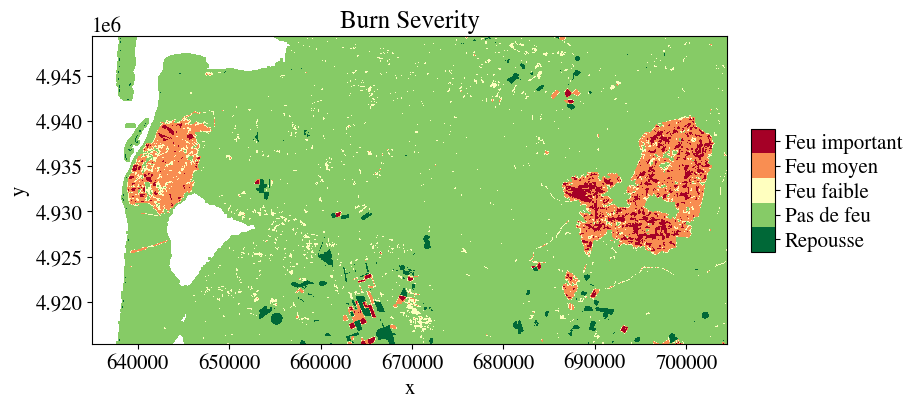

In [10]:
# Importer le filtre gaussien
from scipy.ndimage import gaussian_filter

# Appliquer le filtre sur les données brutes
dataset['smoothed_delta_nbr'] = xr.where(np.isnan(dataset.delta_nbr), 0, dataset.delta_nbr)
dataset['smoothed_delta_nbr'] = (dataset.smoothed_delta_nbr.dims, gaussian_filter(input=dataset.smoothed_delta_nbr.values, sigma=4).astype(np.float32))
dataset['smoothed_delta_nbr'] = xr.where(dataset.smoothed_delta_nbr == 0, np.NaN, dataset.smoothed_delta_nbr)

# Refaire la classification avec le delta_nbr lissé
dataset['burn_severity'] = (dataset.smoothed_delta_nbr.dims, convert_nbr_index(dataset.smoothed_delta_nbr.values, seuils).astype(np.float32))

# Créer la colormap
max_value = 5
burn_cmap = plt.get_cmap('RdYlGn_r', lut=max_value)
burn_legend = ['Repousse', 'Pas de feu', 'Feu faible', 'Feu moyen', 'Feu important']

# Afficher la classification
im = dataset.burn_severity.plot.imshow(figsize=(10, 4), vmin=0.5, vmax=max_value + 0.5, cmap=burn_cmap, add_colorbar=False)

# Créer la colorbar et ajouter les légendes
cbar = plt.colorbar(im, shrink=0.4, aspect=5, pad=0.03)
cbar.set_ticks([i for i in range(1, max_value + 1)])
cbar.set_ticklabels(burn_legend)
plt.title('Burn Severity')

Ensuite il va falloir **masquer une partie des données** pour ne récupérer que l'information intéressante. On  va uniquement s'intéresser aux pixels de forêt de conifères.

> - *Créer une **nouvelle `data variable`** `burn_severity_masked` qui contiendra la donnée des forêts de conifères uniquement.*

Text(0.5, 1.0, 'Burn Severity masked')

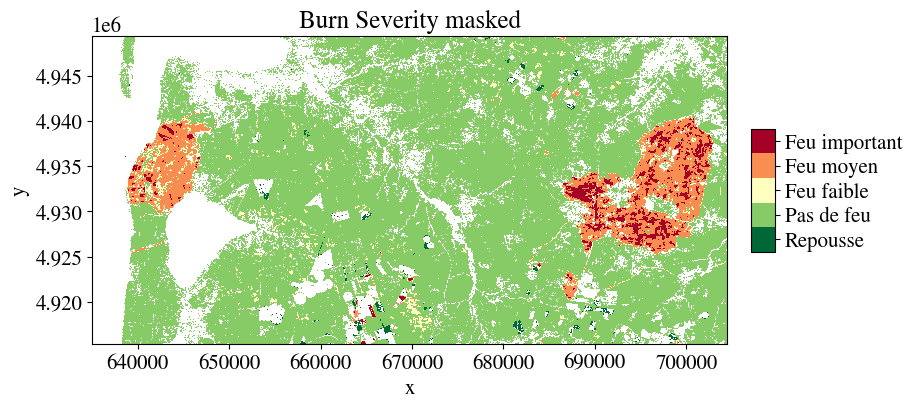

In [11]:
# Créer la nouvelle data variable
dataset['burn_severity_masked'] = dataset.burn_severity * xr.where(OSO_classif == 17, 1, np.NaN)

# Afficher la classification masquée
im = dataset.burn_severity_masked.plot.imshow(figsize=(10, 4), vmin=0.5, vmax=max_value + 0.5, cmap=burn_cmap, add_colorbar=False)

# Créer la colorbar et ajouter les légendes
cbar = plt.colorbar(im, shrink=0.4, aspect=5, pad=0.03)
cbar.set_ticks([i for i in range(1, max_value + 1)])
cbar.set_ticklabels(burn_legend)
plt.title('Burn Severity masked')

On peut maintenant calculer la surface de forêt brulée.

> *En utilisant les **méthodes vues dans les TPs précédents**, calculer la **surface de forêt brulée**.*

In [12]:
# Calculer la surface de forêt brulée
burnt_area = (xr.where((dataset.burn_severity <= 2) | (np.isnan(dataset.burn_severity)), 0, 1).data.sum() * 100) * 1e-6

# Afficher cette surface
print('Size of burnt area =', burnt_area, 'km²')

Size of burnt area = 246.3451 km²


<b><u style="color: red;">COMMENTAIRE</u></b>

D'après internet, la surface de forêt brulée lors des feu de 2022 est de 320 km<sup>2</sup>. Cependant nous obtenons une surface de 246 km<sup>2</sup>, qui est bien inérieure. Cela est du au fait que les feu de l'été 2022 n'ont pas eu lieu que en juin, mais ils ont repris au mois d'août. Pour effectuer un calcul de surface correct de la surface brulée il suffit de considérer des données satellite du mois d'août.